# LA Restaurant Recommender system using Yelp 

## Done By
### Ronak Sankaranarayanan
### Sitanshu Rupani

**Required Readings:** 
* [Yelp Open Dataset](https://www.yelp.com/dataset) 


Here is an example of the data format. More details are included [here](https://www.yelp.com/dataset/documentation/main)

## Business 

'business.json' contain information about local businesses.

```json
{
    // string, 22 character unique string business id
    "business_id": "tnhfDv5Il8EaGSXZGiuQGg",

    // string, the business's name
    "name": "Garaje",

    // string, the full address of the business
    "address": "475 3rd St",

    // string, the city
    "city": "San Francisco",

    // string, 2 character state code, if applicable
    "state": "CA",

    // string, the postal code
    "postal code": "94107",

    // float, latitude
    "latitude": 37.7817529521,

    // float, longitude
    "longitude": -122.39612197,

    // float, star rating, rounded to half-stars
    "stars": 4.5,

    // integer, number of reviews
    "review_count": 1198,

    // integer, 0 or 1 for closed or open, respectively
    "is_open": 1,

    // object, business attributes to values. note: some attribute values might be objects
    "attributes": {
        "RestaurantsTakeOut": true,
        "BusinessParking": {
            "garage": false,
            "street": true,
            "validated": false,
            "lot": false,
            "valet": false
        },
    },

    // an array of strings of business categories
    "categories": [
        "Mexican",
        "Burgers",
        "Gastropubs"
    ],

    // an object of key day to value hours, hours are using a 24hr clock
    "hours": {
        "Monday": "10:00-21:00",
        "Tuesday": "10:00-21:00",
        "Friday": "10:00-21:00",
        "Wednesday": "10:00-21:00",
        "Thursday": "10:00-21:00",
        "Sunday": "11:00-18:00",
        "Saturday": "10:00-21:00"
    }
}
```
## Reviews
```json
{
    // string, 22 character unique review id
    "review_id": "zdSx_SD6obEhz9VrW9uAWA",

    // string, 22 character unique user id, maps to the user in user.json
    "user_id": "Ha3iJu77CxlrFm-vQRs_8g",

    // string, 22 character business id, maps to business in business.json
    "business_id": "tnhfDv5Il8EaGSXZGiuQGg",

    // integer, star rating
    "stars": 4,

    // string, date formatted YYYY-MM-DD
    "date": "2016-03-09",

    // string, the review itself
    "text": "Great place to hang out after work: the prices are decent, and the ambience is fun. It's a bit loud, but very lively. The staff is friendly, and the food is good. They have a good selection of drinks.",

    // integer, number of useful votes received
    "useful": 0,

    // integer, number of funny votes received
    "funny": 0,

    // integer, number of cool votes received
    "cool": 0
}
```

## Restaurant Recommendation System in Las Vegas, Nevada

Users visit Yelp to find information on local businesses, make reservations and post reviews to places they have been. In this project, we will be creating a reccomendation system to show a user similar restaurants based on reviews of other users in the city of Las Vegas Nevada.

In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy or anything else depending on industries).

We use the business and review data sets in the Yelp Data. We limit the project geographically to Las Vegas, Nevada due to computational demands and also as a prototype feature that is being rolled out in a city that has a healthy population of reviews to train our engine on.

This is an interesting problem to tackle as we believe that having the ability to find similar restaurants is a very good feature to have for Yelp users. Recommendations help driving over a third of choices users make online[1]. 


[1]https://knowledge.wharton.upenn.edu/article/recommended-for-you-how-well-does-personalized-marketing-work/

![Advantages of Recommendation Systems in the F&B Industry](RecEngAdv.png "Advantages of Recommendation Systems in the F&B Industry")

The image[2] above shows the increase in user engagement in various sectors such as Sports, Fashion, F&B, etc. when Predictive Content Personalization techniques such as reccomendation engines are used.
The 400% lift in the F&B sector proves it to be a no-brianer to use this very important and rewarding tool in out Yelp app.

[2]https://towardsdatascience.com/5-advantages-recommendation-engines-can-offer-to-businesses-10b663977673

# Data Collection/Processing: 

In [1]:
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from scipy import spatial
from IPython.display import YouTubeVideo

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Library/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
import os
print(os.getcwd())

D:\WPI\Intro to DS\Case Study\01


#### Loading the Datasets

In [5]:
subset_business = pd.read_json("yelp data/yelp_academic_dataset_business.json", lines=True)
subset_checkin = pd.read_json("yelp data/yelp_academic_dataset_checkin.json", lines=True)

The read_json with chunksize creates a json reader object 

A simplified version is, its a list of dataframe that contains 1 million review data in each data frame.

Similar to file reader readlines(), which returns a list that contains each line as a element

In [6]:
reviews = pd.read_json("yelp data/yelp_academic_dataset_review.json", lines=True, orient='columns', chunksize=1000000)

Due to the enormous size of the review dataset and limited computation power, 


we are limiting the number of reviews to 3 Million

In [8]:
count = 0
subset_review = pd.DataFrame()
for review in reviews:
    subset_review = pd.concat([subset_review, review], ignore_index = True)
    count += 1
    if count > 2:
        break   

In [9]:
subset_business.isnull().sum().sort_values(ascending=False)

hours           44843
attributes      29045
categories        524
state               0
stars               0
review_count        0
postal_code         0
name                0
longitude           0
latitude            0
is_open             0
city                0
business_id         0
address             0
dtype: int64

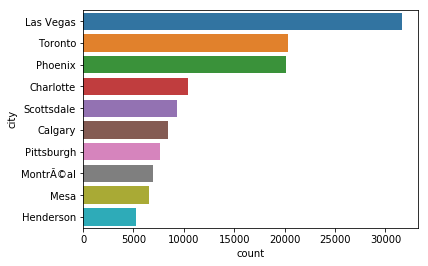

In [11]:
sns.countplot(y = 'city',data=subset_business, order= subset_business['city'].value_counts().index[:10])

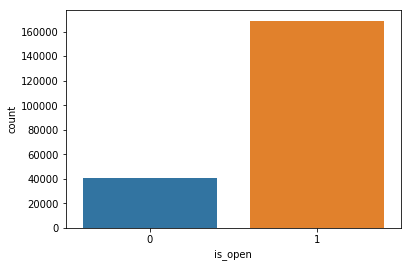

In [12]:
sns.countplot(x = 'is_open',data=subset_business)

Text(0, 0.5, 'Count')

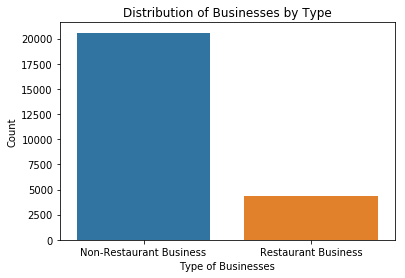

In [49]:
llv = subset_business[(subset_business['city'] == 'Las Vegas') & (subset_business['is_open'] == 1)]
llv.loc[(llv['categories'].str.contains('Restaurant.*')==False), 'cat_type'] = 'Non-Restaurant Business'
llv.loc[(llv['categories'].str.contains('Restaurant.*')==True), 'cat_type'] = 'Restaurant Business'
sns.countplot(x = 'cat_type', data=llv)
plt.title("Distribution of Businesses by Type")
plt.xlabel('Type of Businesses')
plt.ylabel('Count')

#### Filtering Business data

Filtering the business that are in Las Vegas and operating. 

Taking only the restaurants from the business from the categories column.

In [14]:
city = subset_business[(subset_business['city'] == 'Las Vegas') & (subset_business['is_open'] == 1)]
lv = city[['business_id','name','address', 'categories', 'attributes','stars']]
rest = lv[lv['categories'].str.contains('Restaurant.*')==True].reset_index()

In [15]:
rest.head()

,index,business_id,name,address,categories,attributes,stars
0,86,OWkS1FXNJbozn-qPg3LWxg,Mama Napoli Pizza,,"Food, Food Trucks, Restaurants, Pizza","{'RestaurantsDelivery': 'False', 'BusinessAcce...",4.5
1,101,MTx-Zdl_KcU_z9G832XAjg,Taco Bell,8033 N Durango Dr,"Fast Food, Restaurants","{'OutdoorSeating': 'False', 'Alcohol': 'u'none...",2.5
2,157,Yr_w9lakJrKMyEG_hI6zbA,Fat Moe's Pizza & Wings,"6125 W Tropicana Ave, Ste F","Pizza, Salad, Burgers, Restaurants","{'RestaurantsAttire': 'u'casual'', 'Restaurant...",4.0
3,238,AN0bWhisCf6LN9eHZ7DQ3w,Los Olivos Ristorante,3759 E Desert Inn Rd,"Restaurants, Italian","{'WiFi': 'u'free'', 'RestaurantsPriceRange2': ...",5.0
4,246,AtD6B83S4Mbmq0t7iDnUVA,Veggie House,"5115 Spring Mountain Rd, Ste 203","Restaurants, Specialty Food, Japanese, Sushi B...","{'RestaurantsPriceRange2': '2', 'BikeParking':...",4.5


In [16]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 7 columns):
index          4383 non-null int64
business_id    4383 non-null object
name           4383 non-null object
address        4383 non-null object
categories     4383 non-null object
attributes     4339 non-null object
stars          4383 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 239.8+ KB


In [17]:
restaurant = rest[['business_id', 'name', 'address']]
# restaurant.head()

In [18]:
df_review = subset_review[['user_id','business_id','stars', 'date']]
df_review.shape

(3000000, 4)

#### Merging Review and Restaurant Dataset

Merging the Review and restaurant dataset on The Business_ID using the Inner join.

Inner join, 
Only the data entries that are present in both the dataframes are taken. All others are dropped

This will remove the reviews on other restaurants too and business that have no reviews yet.

In [19]:
combined_business_data = pd.merge(df_review, restaurant, on='business_id')
combined_business_data.head()

,user_id,business_id,stars,date,name,address
0,rINCzUH_bgPS9w9PCYkgdA,zcScEL0WEdFkROcnz5379g,3,2013-10-14 22:22:05,The Boiling Crab,4025 S Decatur Blvd
1,FRW6n7zbGf71AivSxS93RA,zcScEL0WEdFkROcnz5379g,5,2017-01-07 07:26:29,The Boiling Crab,4025 S Decatur Blvd
2,VOJAle3tdBbaNBB4g2iqBw,zcScEL0WEdFkROcnz5379g,5,2014-01-09 19:37:19,The Boiling Crab,4025 S Decatur Blvd
3,8Qxj_wOvdDeRbF1yvGZrvQ,zcScEL0WEdFkROcnz5379g,3,2016-03-16 19:01:27,The Boiling Crab,4025 S Decatur Blvd
4,eO9g--X_Uv8eHsc697s8GA,zcScEL0WEdFkROcnz5379g,4,2013-06-11 18:18:59,The Boiling Crab,4025 S Decatur Blvd


In [20]:
combined_business_data.shape

(462238, 6)

#### Format of the dataset

the combined dataframe is formatted such that Restaurants act as Rows, Columns as individual users and stars as values. 

Each row represents the ratings of each restaurant from different users.

Each column represents the ratings given by each user to different restaurants.

Value(i,j) represents the rating of user j on the restaurant i.

In [21]:
rating_crosstab = combined_business_data.pivot_table(values='stars', index='name', columns='user_id', fill_value=0)
rating_crosstab.head()

user_id,---1lKK3aKOuomHnwAkAow,--0sXNBv6IizZXuV-nl0Aw,--0zxhZTSLZ7w1hUD2bEwA,--1mPJZdSY9KluaBYAGboQ,--2OoZVI7f6Q0BRSlLJalQ,--2vR0DIsmQ6WfcSzKWigw,--3WaS23LcIXtxyFULJHTA,--3loIEaXcepp9OKGi_1FQ,--4Nask210pN4sbv6Sw8jQ,--7oh57FmI8_IHX0Q4n-Wg,...,zzpUrEYYdmGcrBcfvfFp3g,zzpgpo54-_P-4rzzBtOuLQ,zzpxVxrXKjv_gjKWUe9PEA,zzrZ8gFESj5pe-SFZ-h0lw,zzrfT1VpnEW0gqq3e_TrVw,zztDqOkbiFnoG2bRUTgDZA,zztkuhvJAqKzecMBIwXrsw,zzvV3l9IqTRX7Db8nxThbA,zzvbRlOYsyOrpuiOrloRew,zzzPVqSxSvjzlLR3Q7wsUw
name,,,,,,,,,,,,,,,,,,,,,
#1 Hawaiian Barbecue,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100 Fires,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2 Scoops of Aloha LV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6500 Tavern,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
664 TJ Birrieria,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
rating_crosstab.shape

(1277, 250811)

#### Spare Matrix

In [23]:
X = rating_crosstab.values

In [24]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Data Exploration: Exploring the Yelp Dataset

**(1) Finding the most popular business categories:** 
* printing the top 10 most popular business categories in the dataset and their counts (i.e., how many business objects in each category). Here we say a category is "popular" if there are many business objects in this category (such as 'restaurants').

##### Taking only the categories and business ID column from the original dataset


Setting 'NULL' to all the empty category values to make the entire column a non null object.

In [25]:
cat = subset_business[['business_id','categories']]
cat.loc[(cat['categories'].isnull()), 'categories'] = 'NULL'
# cat.info()

C:\Users\Ronak\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Ronak\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
# Removing all the spaces that are present inbetween in each category values.
cat['categories'] = cat['categories'].str.replace(" ","")

C:\Users\Ronak\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Taking all the individual category value for each business along with their count in each business. 
i.e each category value will get single count for each business.

Finally sum each category value over the rows. 

Same categories count gets added

In [27]:
s = cat.categories.apply(lambda x: pd.value_counts(x.split(","))).sum(axis = 0)

#### Sorting the Categories in descending order

In [28]:
s.sort_values(ascending=False)[0:10]

Restaurants       63944.0
Shopping          34644.0
Food              32991.0
HomeServices      22487.0
Beauty&Spas       20520.0
Health&Medical    19227.0
LocalServices     15783.0
Automotive        14720.0
Nightlife         14211.0
Bars              12400.0
dtype: float64

**(2) Find the most popular business objects** 
* print the top 10 most popular business objects in the dataset and their counts (i.e., how many checkins in total for each business object).  Here we say a business object is "popular" if the business object attracts a large number of checkins from the users.

#### Merging Checkin and Business Data

The number of checkin for each business is calculated by counting the separator for the date entries (,) and adding one since the last entry will be missed by counting the separator


The Checkin and Business data are merged on Business_ID using Left outer join. 

Left outer join : 
The data entries that are only present in right datafram (Business) and not in Left datafram(Checkin) are dropped.
The data entries from the left datafrane are given primary preference and are added even if the data aren't available in the right dataframe.


Each business data with their checkin count, name and address are taken and stored in check_in_count.

In [29]:
c = subset_checkin
c['Count']=c['date'].str.count(',').add(1)

check_in_business = pd.merge(c, subset_business[['business_id','name','address','city','state']], on='business_id', how='left')
check_in_count = check_in_business[['name', 'address', 'city', 'state', 'Count']]

In [30]:
check_in_count.head()

,name,address,city,state,Count
0,The Spicy Amigos,821 4 Avenue SW,Calgary,AB,7
1,John's Chinese BBQ Restaurant,"328 Highway 7 E, Chalmers Gate 11, Unit 10",Richmond Hill,ON,189
2,Primal Brewery,16432 Old Statesville Rd,Huntersville,NC,193
3,Valley Bone and Joint Specialists,"3941 E Baseline Rd, Ste 102",Gilbert,AZ,1
4,Great Clips,"1835 E Guadalupe Rd, Ste 106",Tempe,AZ,38


Business can exist with different branch in different places each having their own review, checkin and business ID. 

We group all the business with the same name and sum all the count of check in. 

And finally sort the count values in descending values and display the top 10 business.

In [32]:
check_in_business.groupby(['name']).sum().sort_values(by='Count',ascending=False)[0:10]

,Count
name,
Starbucks,380896
McCarran International Airport,151671
Phoenix Sky Harbor International Airport,129355
Target,94057
McDonald's,64250
Chipotle Mexican Grill,63777
LA Fitness,63437
In-N-Out Burger,59694
Charlotte Douglas International Airport,59306


The two most common types of recommender systems are **Content-Based** and **Collaborative Filtering (CF)**. 

* Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the "wisdom of the crowd" to recommend items. 
* Content-based recommender systems focus on the attributes of the items and give you recommendations based on the similarity between them.

In our solution, we opt for **Collaborative Filtering (CF)**. We select this method as it gives better results and is relatively easy to understand (from an overall implementation perspective). The algorithm has the ability to do feature learning on its own, which means that it can start to learn for itself what features to use.

CF can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. 

In this project, we will implement Model-Based CF by using singular value decomposition (SVD) and Memory-Based CF by computing cosine similarity. 









Singular Value Decomposition (SVD) is a popular method in linear algebra for matrix factorization in machine learning. Such a method shrinks the space dimension from N-dimension to K-dimension (where K<N) and reduces the number of features. SVD constructs a matrix with the row of users and columns of items and the elements are given by the users’ ratings. Singular value decomposition decomposes a matrix into three other matrices and extracts the factors from the factorization of a high-level (user-item-rating) matrix.

![SVD](SVD_pic_2.png)

U and V are orthogonal Matrix eigenvectors taken from A.AT and AT.A respectively

S is a diagonal matrix with root of eigenvalues.

#### Write codes to implement the solution in python:

We use TruncatedSVD from sklearn to compress the transposed matrix into down to a number of rows by 12 matrices. All of the restaurants are in the rows. But the users will be compressed down to 12 components arbitrarily that represent a generalized view of users' tastes.

TruncateSVD returns Dot product of U and S, discarding the rest of the matrix.
This is a Reduced version of SVD

In [33]:
SVD = TruncatedSVD(n_components=12, random_state=17)
result_matrix = SVD.fit_transform(X)
result_matrix.shape

(1277, 12)

#### Correlation Matrix


In [34]:
corr_matrix = np.corrcoef(result_matrix)
corr_matrix.shape

(1277, 1277)

Finding the restaurant business_id with most number of stars.

In [35]:
combined_business_data.groupby('business_id')['stars'].count().sort_values(ascending=False).head()

business_id
RESDUcs7fIiihp38-d6_6g    10417
f4x1YBxkLrZg652xt2KR5g     6859
DkYS3arLOhA8si5uUEmHOw     5319
5LNZ67Yw9RD6nf4_UhXOjw     4973
vHz2RLtfUMVRPFmd7VBEHA     4405
Name: stars, dtype: int64

In [36]:
popular_business_id = combined_business_data.groupby('business_id')['stars'].count().sort_values(ascending=False).head().index[0]

Taking the name and the address of the most popular restaurant

In [37]:
Filter = combined_business_data['business_id'] == popular_business_id
popular_business_name = combined_business_data[Filter]['name'].unique()
print("Name: ", combined_business_data[Filter]['name'].unique())
print("Address:", combined_business_data[Filter]['address'].unique())

Name:  ['Bacchanal Buffet']
Address: ['3570 S Las Vegas Blvd']


Saving all the restaurant names.

Finaing the index of the most popular restaurant : Bacchanal Buffet

In [38]:
restaurant_names = rating_crosstab.index
restaurants_list = list(restaurant_names)

popular_rest = restaurants_list.index(popular_business_name)
print("index of the popular restaurant: ", popular_rest)

index of the popular restaurant:  59


Finding the row of the popular restaurant in the correlation matrix

In [39]:
corr_popular_rest = corr_matrix[popular_rest]
corr_popular_rest.shape

(1277,)

Finding the names of the restaurant that are closely correlated to the given restaurant in the list of restaurant names

In [40]:
list(restaurant_names[np.argsort(corr_popular_rest)[-4:-1]])

['La Bonita Taco Shop', 'Pizzeria Pronto', 'Waterside Cafe']

#### Similarity between the restaurant and the Recommended restaurants

Finding the Cosine similarity between the restaurant and recommended restaurants.

Find the cosine distance between the restaurant and recommended restaurants

Similarity  = 1 - cosine distance.


In [42]:
restaurant = result_matrix[popular_rest]
for i in list(restaurant_names[np.argsort(corr_popular_rest)[-4:-1]]):
    corr_index = restaurants_list.index(i)
    recommended_rest = result_matrix[corr_index]
    similarity = 1 - spatial.distance.cosine(restaurant, recommended_rest)
    print('Similarity between {} and {} is {}'.format(popular_business_name[0], i, similarity))

Similarity between Bacchanal Buffet and La Bonita Taco Shop is 0.6674919362709246
Similarity between Bacchanal Buffet and Pizzeria Pronto is 0.9901381435966199
Similarity between Bacchanal Buffet and Waterside Cafe is 0.9796879656246462


In [47]:
#testing_business_id = combined_business_data.groupby('business_id')['stars'].count().sort_values(ascending=False).head(3).index
testing_business_id = combined_business_data['business_id'].sample(3, random_state = 42)
#testing_business_id = combined_business_data.groupby('business_id')['stars'].count().index
for i in testing_business_id:
    business_name = combined_business_data[combined_business_data['business_id'] == i]['name'].unique()
    business_index = restaurants_list.index(business_name)
    corr_rest = corr_matrix[business_index]
    restaurant = result_matrix[popular_rest]
    for j in list(restaurant_names[(np.argsort(corr_rest)[-4:-1])]):
        corr_index = restaurants_list.index(j)
        recommended_rest = result_matrix[corr_index]
        similarity = 1 - spatial.distance.cosine(restaurant, recommended_rest)
        print('{} and {} = {}'.format(business_name[0], j, similarity))

Karved and Rooster Boy Cafe = 0.06145055314219405
Karved and Soho Sushi Burrito = 0.15041960090052808
Karved and Pizza Rock = 0.11588833175737179
D' Pinoy Joint and Goldilocks = 0.1947773194266944
D' Pinoy Joint and Cutting Board Filipino Gastropub = 0.16793843965124688
D' Pinoy Joint and The Boiling Crab = 0.1613169544208296
Noodle Asia and The Coffee Shop = 0.3730005378851513
Noodle Asia and Le Village Buffet = 0.5770932286532635
Noodle Asia and Pho Vietnamese Cuisine = 0.5710883907901876


A Reference Video on Recommendation Systems

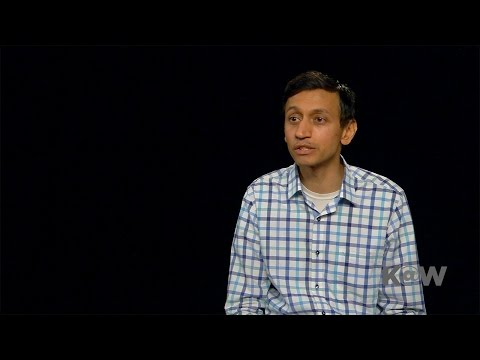

In [2]:
YouTubeVideo('EyssdpQz1KY', width=800, height=300)